# Reddit Sentiment Analysis: Public Attitudes Toward NYC's Migrant Crisis and Political Implications

## Introduction
Since 2022, New York City (and the rest of the United States) has seen a major influx of migrants usually seeking refuge from political turmoil, economic instability, or violence in their home countries. The city has since faced challenges in providing adequate housing, healthcare, education, and other basic services to incoming people, which has put significant strains on public resources and created tensions between providing support to migrants and managing the expectations of local residents. To delve deeper into the conflict, this project will be a sentiment analysis of comments under Reddit posts with a focus on attitudes toward the ongoing migrant crisis in New York City.

## Significance
The migrant crisis is a controversial, “hot button” issue in American politics and has been repeatedly cited as a determining factor in US citizens’ decisions to vote for Kamala Harris, Donald Trump, or an independent prospect in the most recent Presidential election because of how these candidates have each proposed to address the problem. Likewise, the topic has not only been brought up numerous times in debates, interviews, and rallies with the presidential candidates, but it is also frequently discussed heatedly among other prominent political and academic figures as well as the general public on social media.

Based on the findings of the sentiment analysis, we may be able to get a more concrete sense of how the constituents of different political parties view the migrant crisis and whether there is a dominating opinion. This can also inform government officials and policymakers on what kinds of policies to put forward or what stance to take in order to gain the favor of key stakeholders in the future.

## Research Question
This project will be a sentiment analysis of Reddit with a focus on bipartisan attitudes toward the ongoing migrant crisis in New York City. I will investigate the following research question: How do public discussions about the migrant crisis in New York City on social media platforms like Reddit reflect varying attitudes on the issue, and what potential implications might these sentiment trends have for broader political inclinations?


## Hypothesis
I hypothesize that the analysis will find a generally negative sentiment among NYC residents regarding the migrant crisis in the city, and by association, more people (Reddit commenters) will favor conservative values and policies that reflect an opposition to permitting more immigrants into the country as asylum seekers.

### Data Collection via the Reddit API
In order to collect my data, I used the PRAW package. PRAW is a "Python Reddit API Wrapper" that makes it simpler to work with the Reddit API. To start, the PRAW documentation instructed me to create a Reddit Developer account and create a new project on their platform. The new project gave me a unique `client_id` and `client_secret` that I used to get a `Reddit` "instance".

I then used the `subreddit()` function to get access to `r/nyc`, `r/newyorkcity`, and `r/AskNYC`. I narrowed my data collection to these subreddits in an effort to target NYC residents or those who are more familiar with the migrant crisis. I then used PRAW to perform a search for the phrase "migrant crisis" in each subreddit and limited the results to the 100 most relevant results. I settled on the 100 most relevant posts through a bit of trial and error until it resulted in a reasonable number of total comments.

Once I got the relevant posts back from the API, I constructed an `all_comments` list from the comments in the posts and pulled out `comment.body` and `comment.created_utc` as relevant columns. One thing that I found later on while looking at my CSV file was that I had a lot of duplicate comments that were coming from moderator bot accounts in the subreddits. Most of the subreddits seem to use a bot called "AutoModerator", so I was able to exclude comments from this bot using the `comment.author.name` field.

Finally, I converted my `all_comments` list to a `DataFrame` and saved them to a CSV file.

In [2]:
!pip install praw

# Praw kept printing warnings suggesting I should use asyncpraw, this hides the warnings
import logging
logging.getLogger("praw").setLevel(logging.ERROR)

# Import Python Reddit API wrapper library - https://github.com/praw-dev/praw
import praw
import pandas as pd

# Create reddit instance using app created for this project
reddit = praw.Reddit(
    client_id="Ab9LwDryTzif1cSvx2ybMQ",
    client_secret="kS1yk4SczYH7iVN3ks6jfyxSOQAnnw",
    user_agent="NYC Migrant Crisis Sentiment Analysis Project",
)

nyc_subreddit = reddit.subreddit("nyc")
newyorkcity_subreddit = reddit.subreddit("newyorkcity")
asknyc_subreddit = reddit.subreddit("AskNYC")

all_subreddits = [nyc_subreddit, newyorkcity_subreddit, asknyc_subreddit]

all_comments = []

# for subreddit in all_subreddits:
#   for post in subreddit.search("migrant crisis", limit=100):
#     # This expands the post comments to include all of them
#     post.comments.replace_more(limit=None)
#     for comment in post.comments.list():
#       # Exclude AutoModerator Reddit bot account comments
#       if comment.author and comment.author.name == 'AutoModerator':
#         continue
#       else:
#         all_comments.append({'comment': comment.body, 'date': comment.created_utc})

# pd.DataFrame(all_comments).to_csv("reddit_comments.csv", index=False)
comments_df = pd.read_csv("reddit_comments.csv")
comments_df

,comment,date
0,it’s ridiculous and flat out corrupt. Someone ...,1.723645e+09
1,5 billion.... that's a '2nd avenue subway' a y...,1.723647e+09
2,How are these costs not attempted to be mitiga...,1.723644e+09
3,This issue should be handled at the federal le...,1.723644e+09
4,We will be paying for this for at least 10 yea...,1.723652e+09
...,...,...
14563,"Nah, more like since the 1600s. The crisis sta...",1.723334e+09
14564,At least 60% of the migrants are working music...,1.710043e+09
14565,"Holy smokes, what the hell do migrants have to...",1.710042e+09
14566,"Dang, that took a real hard turn at the end. \...",1.710041e+09


### Data Cleaning
The next step was to do some general cleaning of the dataframe. I dropped any rows that had duplicate comments using `drop_duplicates()`, which reduced my dataframe size from 14568 rows to 13712. I noticed that Reddit uses "[deleted]" and "[removed]" as placeholders for comments that a user or moderator deletes, so I removed those comments from the dataframe as well.

Finally, the date format that the Reddit API gave me was "UTC". Some research told me that this format is a ["Unix timestamp"](https://en.wikipedia.org/wiki/Unix_time) which represents a date as the number of seconds since 00:00:00 UTC on 1 January 1970.

I remembered that we used the Pandas `DateTime` format more frequently when learning different methods of analysis, so I used `to_datetime()` to convert the `date` column to that format.

In [3]:
!pip install --upgrade nltk

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.probability import FreqDist

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
stops = stopwords.words('english')

print("Number of rows before dropping dupes: " + str(len(comments_df)))
comments_df.drop_duplicates(subset=['comment'], inplace=True)
print("Number of rows after dropping dupes: " + str(len(comments_df)))

# Find comments that are [deleted] or [removed]
comments_df = comments_df[comments_df['comment'] != '[deleted]']
comments_df = comments_df[comments_df['comment'] != '[removed]']

print("Number of rows after dropping [deleted] or [removed] comments: " + str(len(comments_df)))

# Converting date column from Unix seconds to datetime
comments_df['date'] = pd.to_datetime(comments_df['date'], unit='s')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Number of rows before dropping dupes: 14568
Number of rows after dropping dupes: 13712
Number of rows after dropping [deleted] or [removed] comments: 13710


### Sentiment Analysis Using VADER
Once my data was generally cleaned, I proceeded with the main analysis method: sentiment analysis using VADER. I imported `SentimentIntensityAnalyzer` and updated my dataframe to use the `date` column as the index. I then sorted the dataframe using the date index to get it into chronological order based on comment date.

Next, I reused the `calculate_sentiment()` function from course lecture notes to get the compound polarity score of each comment. Using these compound scores, I plotted a line graph of the change in average sentiment per month.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.8 MB/s eta 0:00:00


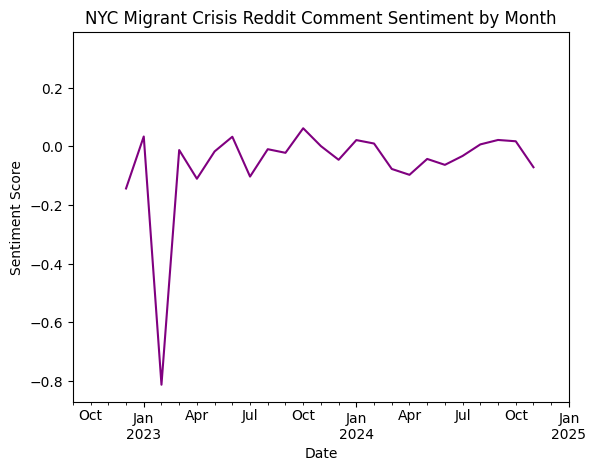

In [4]:
!pip install vaderSentiment matplotlib

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

sentimentAnalyzer = SentimentIntensityAnalyzer()

# Check if date column is already the index
if 'date' not in comments_df.index.names:
  # Make date the index of the DataFrame
  comments_df = comments_df.set_index('date')

# Sort the index to ensure it's monotonic
comments_df = comments_df.sort_index()

# Function that returns the compound polarity score for a comment
def calculate_sentiment(comment):
    # Run VADER on the text
    scores = sentimentAnalyzer.polarity_scores(comment)
    # Extract the compound score
    compound_score = scores['compound']
    # Return compound score
    return compound_score

# Store compount score in sentiment_score column
comments_df['sentiment_score'] = comments_df['comment'].apply(calculate_sentiment)

plt.figure()
comments_df.resample('ME')['sentiment_score'].mean().plot(
    title="NYC Migrant Crisis Reddit Comment Sentiment by Month",
    color="purple",
    xlabel="Date",
    ylabel="Sentiment Score",
    xlim=('2022-09-01', '2025-01-01')
);

### Data Categorization Based On Sentiment
Once I had the `sentiment_score` in the dataframe, I categorized/labeled the comments based on their respective compound scores. Following guidelines from a similar Reddit-based sentiment analysis tutorial, I deemed a score of `> 0.2` as positive and labeled it as `1`, a score of `< -0.2` as negative and labeled it as `-1`, and all scores in between as neutral with a label of `0`.

I stored this label in a new `sentiment_label` column and used it to calculate the percentage distribution. I then visualized the percentage distribution in a bar chart for the three categories.

sentiment_label
-1    34.704595
 1    34.194019
 0    31.101386
Name: proportion, dtype: float64


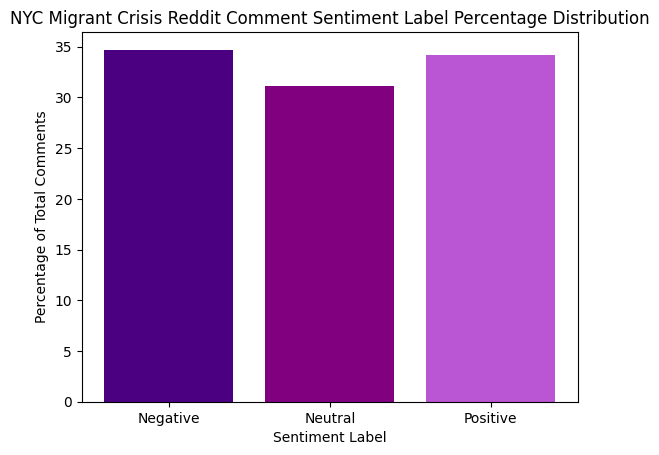

In [5]:
# Create sentiment_label column that categorizes:
# > 0.2 sentiment_score = 1 (positive), < -0.2 sentiment_score = -1 (negative)
# Method taken from: https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
comments_df['sentiment_label'] = 0
comments_df.loc[comments_df['sentiment_score'] > 0.2, 'sentiment_label'] = 1
comments_df.loc[comments_df['sentiment_score'] < -0.2, 'sentiment_label'] = -1

# Calculate percentage distribution for the categories
sentiment_label_percentages = comments_df['sentiment_label'].value_counts(normalize=True) * 100
print(sentiment_label_percentages)

plt.figure()
plt.bar(
    sentiment_label_percentages.index,
    sentiment_label_percentages.values,
    color=["indigo", "mediumorchid", "purple"],
    tick_label=['Negative', 'Positive', 'Neutral'],
)
plt.title('NYC Migrant Crisis Reddit Comment Sentiment Label Percentage Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Percentage of Total Comments')
plt.show()

### Processing and Standardizing Comments
After conducting the sentiment analysis, I wanted to deepen my analysis by investigating word frequencies across all of the comments and within the different sentiment categories. In order to do this, I had to perform additional processing on the dataframe.

To start, I standardized all comments to lowercase, removed punctuation, and only kept alphabetical words using the `make_lowercase_if_alpha()` function adapted from lecture. Next, I removed any words from the comments that are in NLTK's list of `stopwords` to limit my analysis to words that have true semantic meaning. Finally, I reused the `get_wordnet_pos()` function in tandem with the `WordNetLemmatizer` from NTLK to lemmatize the words in each comment by mapping each word to its part of speech to help the lemmatizer determine what grammatical structure (if any) to remove from the words.

In [6]:
# Function to make words lowercase if they are alphabetical
def make_lowercase_if_alpha(comment):
  # Splits string into words
  words = comment.split()
  # Keeps a word and makes it lowercase if it is alphabetical
  filtered_words = [word.lower() for word in words if word.isalpha()]
  # Combines words back into a single string
  return ' '.join(filtered_words)

# Standardize all comments to lowercase, remove punctuation, and only keep alphabetical words
comments_df['comment'] = comments_df['comment'].apply(make_lowercase_if_alpha)

# Function to remove stopwords from a string
def remove_stopwords(comment):
  # Splits string into words
  words = comment.split()
  # Filters out words that are in stops list
  filtered_words = [word for word in words if word not in stops]
  # Combines words back into a single string
  return ' '.join(filtered_words)

# Removing stopwords from comments
comments_df['comment'] = comments_df['comment'].apply(remove_stopwords)

wordnet_lemmatizer = WordNetLemmatizer()

# Function to get POS tag for a word, from lecture
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Function to lemmatize words using WordNetLemmatizer and get_wordnet_pos function
def lemmatize_words(comment):
  # Splits string into words
  words = comment.split()
  # Lemmatizes words
  lemmatized_words = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
  # Combines words back into a single string
  return ' '.join(lemmatized_words)

comments_df['comment'] = comments_df['comment'].apply(lemmatize_words)
comments_df

,comment,sentiment_score,sentiment_label
date,,,
2020-04-07 11:05:18,spoke mother law hysterical food asian communi...,-0.8360,-1
2020-04-07 11:44:36,walk chinatown yesterday place ghost think saw...,-0.3182,-1
2020-04-07 12:21:19,truck driver barely want drive city much less ...,0.0018,0
2020-04-07 12:22:35,happen mean friend discriminate include one nu...,0.2960,1
2020-04-07 18:35:16,restaurant close week many already lose custom...,-0.3182,-1
...,...,...,...
2024-11-27 10:22:05,know guy believe thing work real,0.0000,0
2024-11-27 17:06:51,see math difficult subject rich rich,-0.2081,-1
2024-11-27 17:17:01,practical american little net stark division rich,-0.2291,-1


### Positive Word Frequency Distribution
Now that my comments dataframe was fully processed and prepared for additional analysis at the word level, I proceeded by filtering the dataframe on the `sentiment_label` column to only get the positive comments (those that have `1` as their label).

Replicating a technique from the aforementioned Reddit sentiment analysis tutorial, I used NLTK's `FreqDist` to create a dictionary of the most common words in this subset of positive comments.

I used these frequencies to create a graph that has each word's frequency (number of occurrences across all of the positive comments) on the y-axis and the ranking of that word's frequency out of all 7,538 unique words in the positive comments list.

[('people', 1227), ('like', 1012), ('get', 921), ('migrant', 727), ('go', 653), ('would', 650), ('city', 634), ('work', 596), ('make', 589), ('nyc', 507), ('want', 498), ('come', 494), ('think', 488), ('say', 479), ('one', 437), ('need', 418), ('take', 407), ('new', 407), ('asylum', 397), ('even', 392), ('well', 389), ('state', 358), ('border', 351), ('give', 348), ('know', 347), ('u', 337), ('pay', 335), ('free', 324), ('country', 316), ('good', 302), ('see', 295), ('money', 288), ('also', 285), ('right', 283), ('tax', 272), ('vote', 267), ('thing', 264), ('immigrant', 262), ('use', 258), ('way', 256), ('help', 253), ('year', 252), ('many', 247), ('could', 245), ('much', 243), ('immigration', 241), ('try', 237), ('support', 236), ('actually', 229), ('job', 228), ('adam', 221), ('care', 221), ('live', 221), ('lol', 218), ('republican', 218), ('time', 216), ('really', 214), ('housing', 209), ('look', 207), ('government', 205), ('issue', 203), ('lot', 199), ('federal', 195), ('never', 19

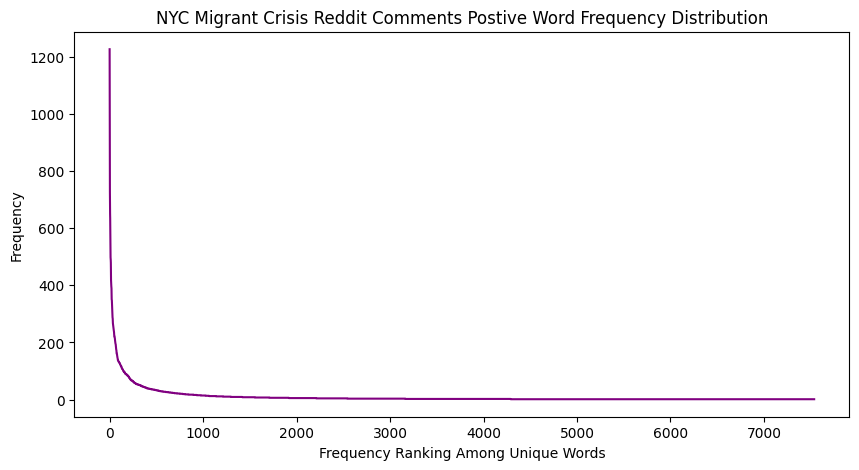

In [7]:
# Filter DF to only get comments that have a positive sentiment_label
# Method and visualization also taken from: https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/
pos_comments = list(comments_df[comments_df.sentiment_label == 1].comment)
# FreqDist requires words/tokens
pos_comments_tokens = [word for comment in pos_comments for word in comment.split() if word]
pos_comments_word_freq_dist = FreqDist(pos_comments_tokens)
print(pos_comments_word_freq_dist.most_common(100))
print("Number of unique words in the positive comments list: ", len(pos_comments_word_freq_dist))

pos_comments_frequencies = [x[1] for x in pos_comments_word_freq_dist.most_common()]

plt.figure(figsize=(10,5))
plt.plot(pos_comments_frequencies, color="purple")

plt.xlabel("Frequency Ranking Among Unique Words")
plt.ylabel("Frequency")
plt.title("NYC Migrant Crisis Reddit Comments Postive Word Frequency Distribution")
plt.show()

### Negative Word Frequency Distribution
I repeated the same steps, but for the negative comments subset, which has 7,845 unique words.

[('people', 1525), ('get', 1104), ('migrant', 898), ('city', 844), ('would', 750), ('go', 745), ('make', 706), ('say', 590), ('come', 565), ('like', 561), ('one', 551), ('nyc', 544), ('even', 517), ('need', 506), ('work', 486), ('want', 480), ('asylum', 478), ('think', 476), ('border', 466), ('illegal', 444), ('take', 430), ('new', 429), ('know', 409), ('state', 406), ('pay', 391), ('immigrant', 390), ('immigration', 374), ('right', 372), ('problem', 370), ('u', 363), ('fuck', 362), ('country', 360), ('year', 338), ('see', 328), ('bad', 321), ('also', 313), ('try', 294), ('republican', 276), ('stop', 275), ('give', 275), ('government', 273), ('time', 270), ('federal', 268), ('many', 266), ('issue', 266), ('use', 258), ('adam', 254), ('way', 254), ('much', 244), ('actually', 243), ('money', 241), ('thing', 240), ('back', 238), ('vote', 238), ('policy', 235), ('job', 233), ('could', 233), ('shelter', 231), ('shit', 228), ('crisis', 228), ('tax', 224), ('really', 223), ('biden', 222), ('l

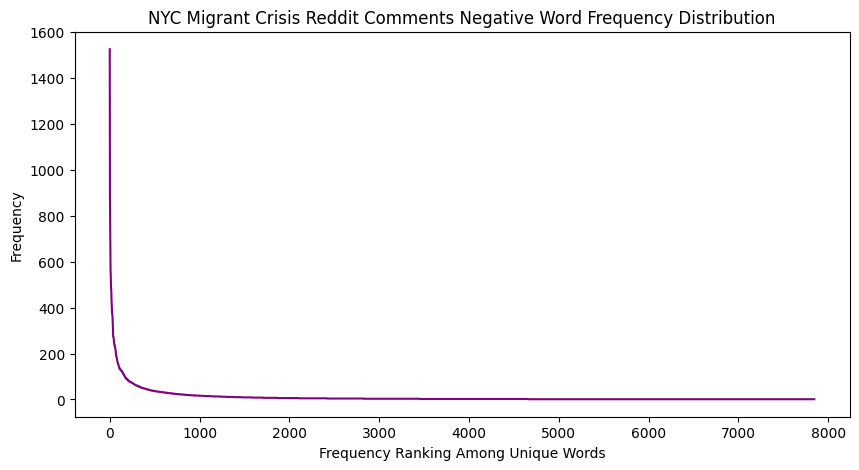

In [8]:
# Repeat process for negative commments
neg_comments = list(comments_df[comments_df.sentiment_label == -1].comment)
neg_comments_tokens = [word for comment in neg_comments for word in comment.split() if word]
neg_comments_word_freq_dist = FreqDist(neg_comments_tokens)
print(neg_comments_word_freq_dist.most_common(100))
print("Number of unique words in the negative comments list: ", len(neg_comments_word_freq_dist))

neg_comments_frequencies = [x[1] for x in neg_comments_word_freq_dist.most_common()]

plt.figure(figsize=(10,5))
plt.plot(neg_comments_frequencies, color="purple")

plt.xlabel("Frequency Ranking Among Unique Words")
plt.ylabel("Frequency")
plt.title("NYC Migrant Crisis Reddit Comments Negative Word Frequency Distribution")
plt.show()

### Word Cloud Visualization
To wrap up my analysis, I used the processed dataframe to build a word cloud visualization of the most common words across all of the comments — regardless of their sentiment category.

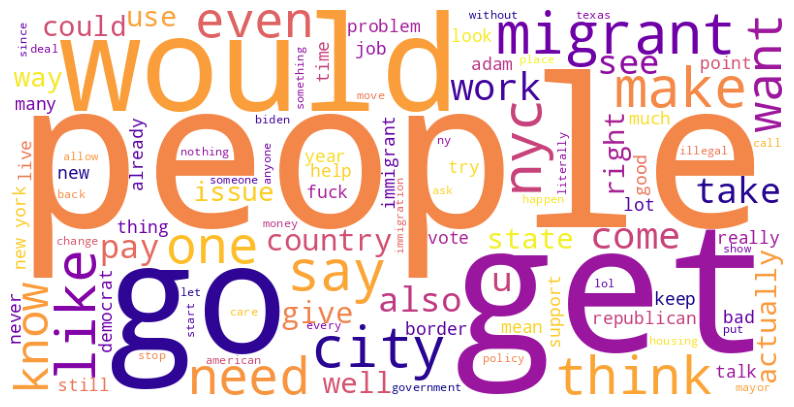

In [9]:
!pip install wordcloud

# Word cloud visualization taken from lecture link: https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud

# WordCloud requires a single string, so we need to combine all comments into one string
comments_as_string = " ".join(comment for comment in comments_df['comment'])

# Create the WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=stops,
    colormap="plasma",
    max_words=100
).generate(comments_as_string)

# Show the WordCloud using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Discussion of Results

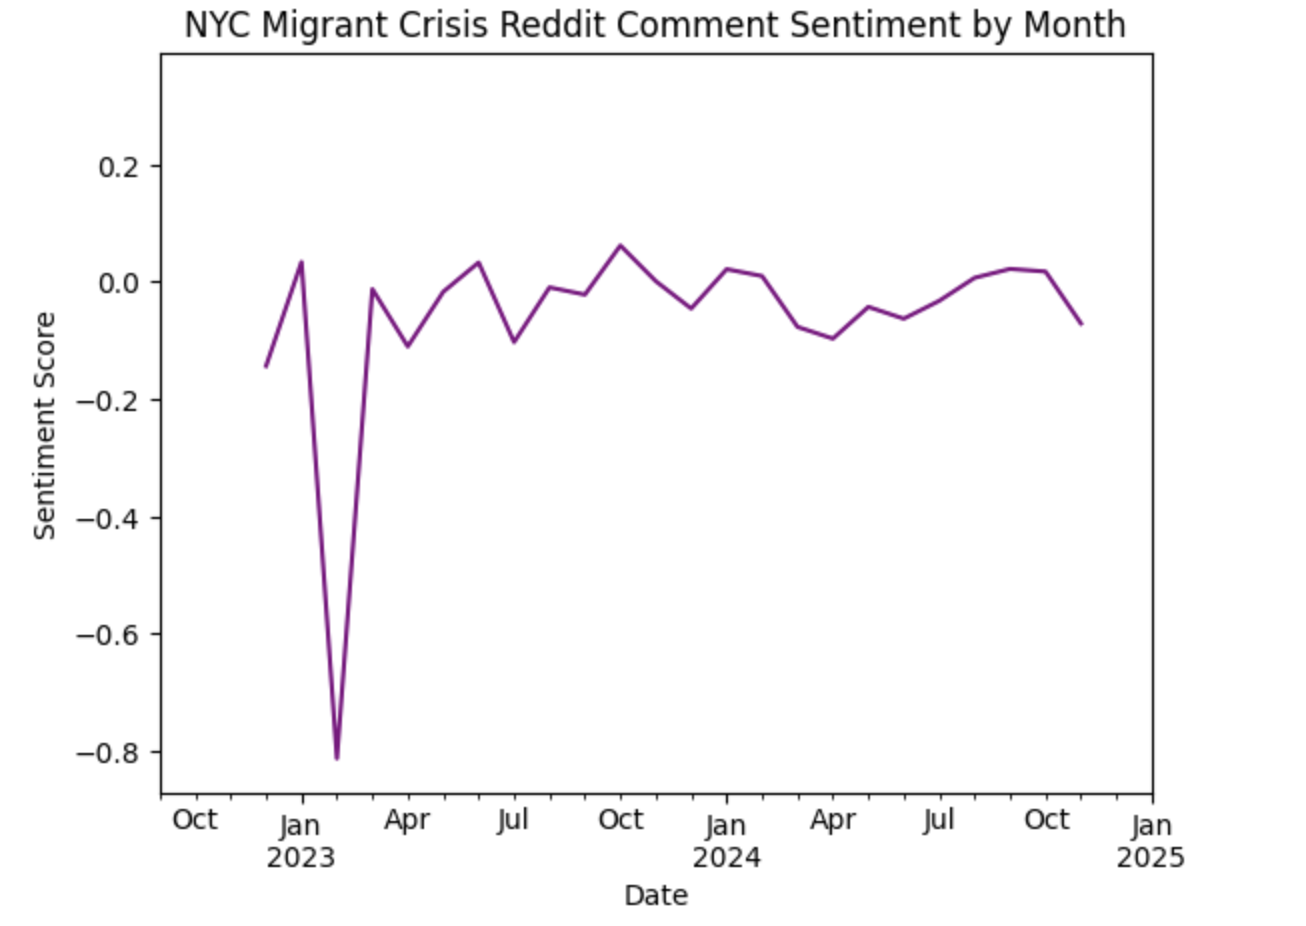

This line graph visualizes the changes in Reddit comment sentiment by month starting in October 2023. The general sentiment surrounding the migrant crisis among commenters has been slightly negative-leaning over the past two years with minor fluctuations; the trend hovers around 0 but mostly between 0 and -1. There is an anomaly in January 2023 that presents a deeply negative sentiment towards the migrant crisis, and this may have been caused by a significant event or shift in public discourse related to the issue in the United States that would impact New York City. I looked at different current events that occurred in the United States in January and Feburary of 2023, and one possible factor was that President Biden declared a series of border policy initiatives to manage increasing arrivals of migrants, including tighter restrictions, lawful pathways, and increased border security resources, at the United States-Mexico border. Nevertheless, this is merely speculation and would require evidence to be made into a proper claim.

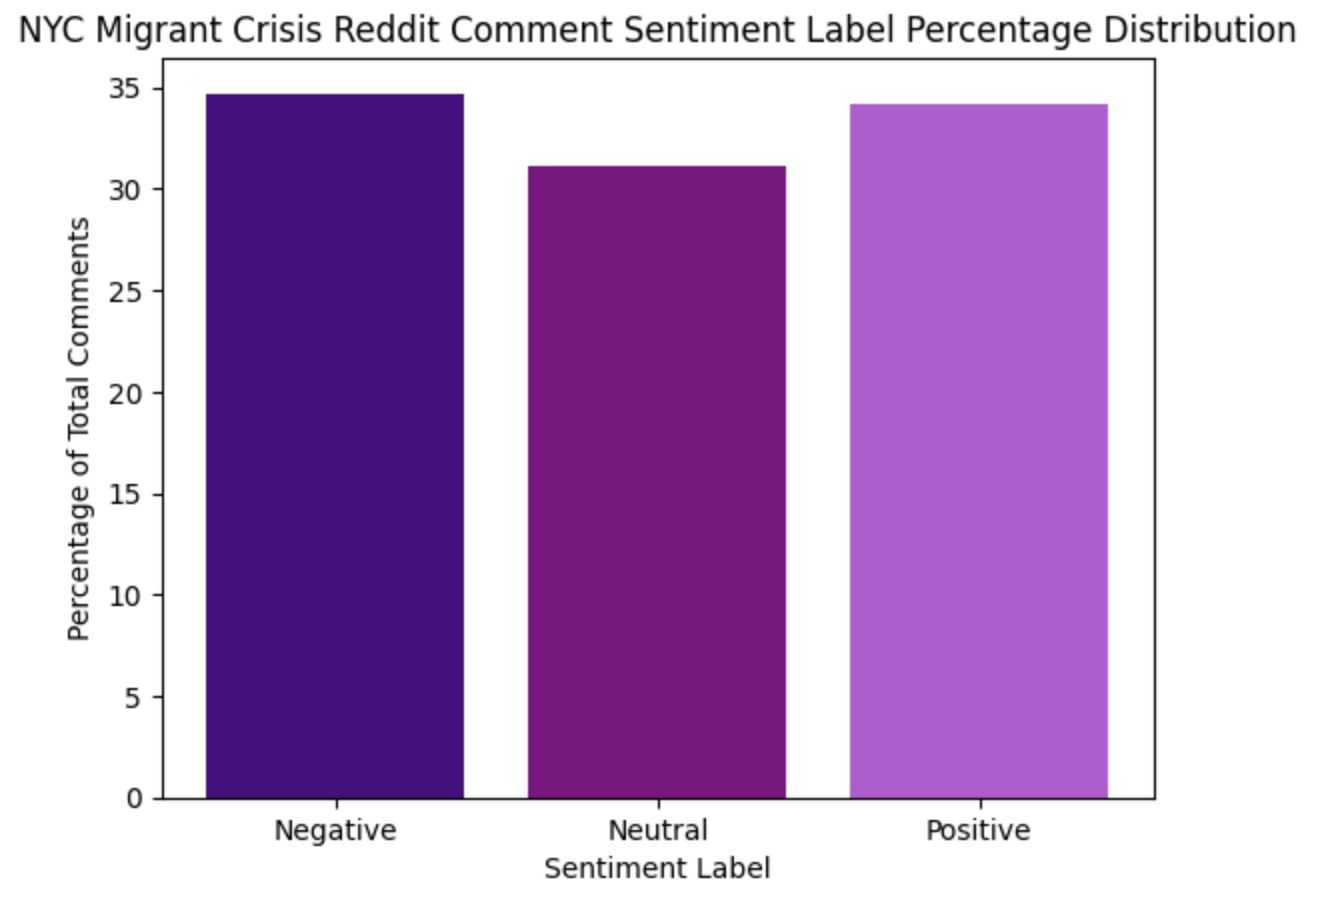

The bar graph exhibits that there is a marginally higher percentage of negative comments than positive comments after focusing the analysis on comments with stronger language. To achieve this narrowed focus, I sorted comments into new categories based on the compound polarity scores assigned by VADER, only with slightly altered parameters. Consequently, comments with scores greater than 0.2 are positive, comments with scores less than -0.2 are negative, and comments with scores between -0.2 to 0.2 are neutral. For the sake of simplicity, these were kept under the original labels of 1, -1, and 0, respectively.

VADER can be flawed, especially when dealing with the complex language nuances in social media text as it is primarily rule-based. The purpose of enlarging the “neutral” boundaries through the recategorization is to ensure that the more ambiguous comments are controlled for in the analysis and we are avoiding any potential misclassifications. Ambiguous comments that are floating in the grey area do not provide much insight into positive or negative impacts and can even be mistaken as one or the other due to neutral language. In this graph, I only wanted to include the comments that were deemed strongly or certainly negative or positive.

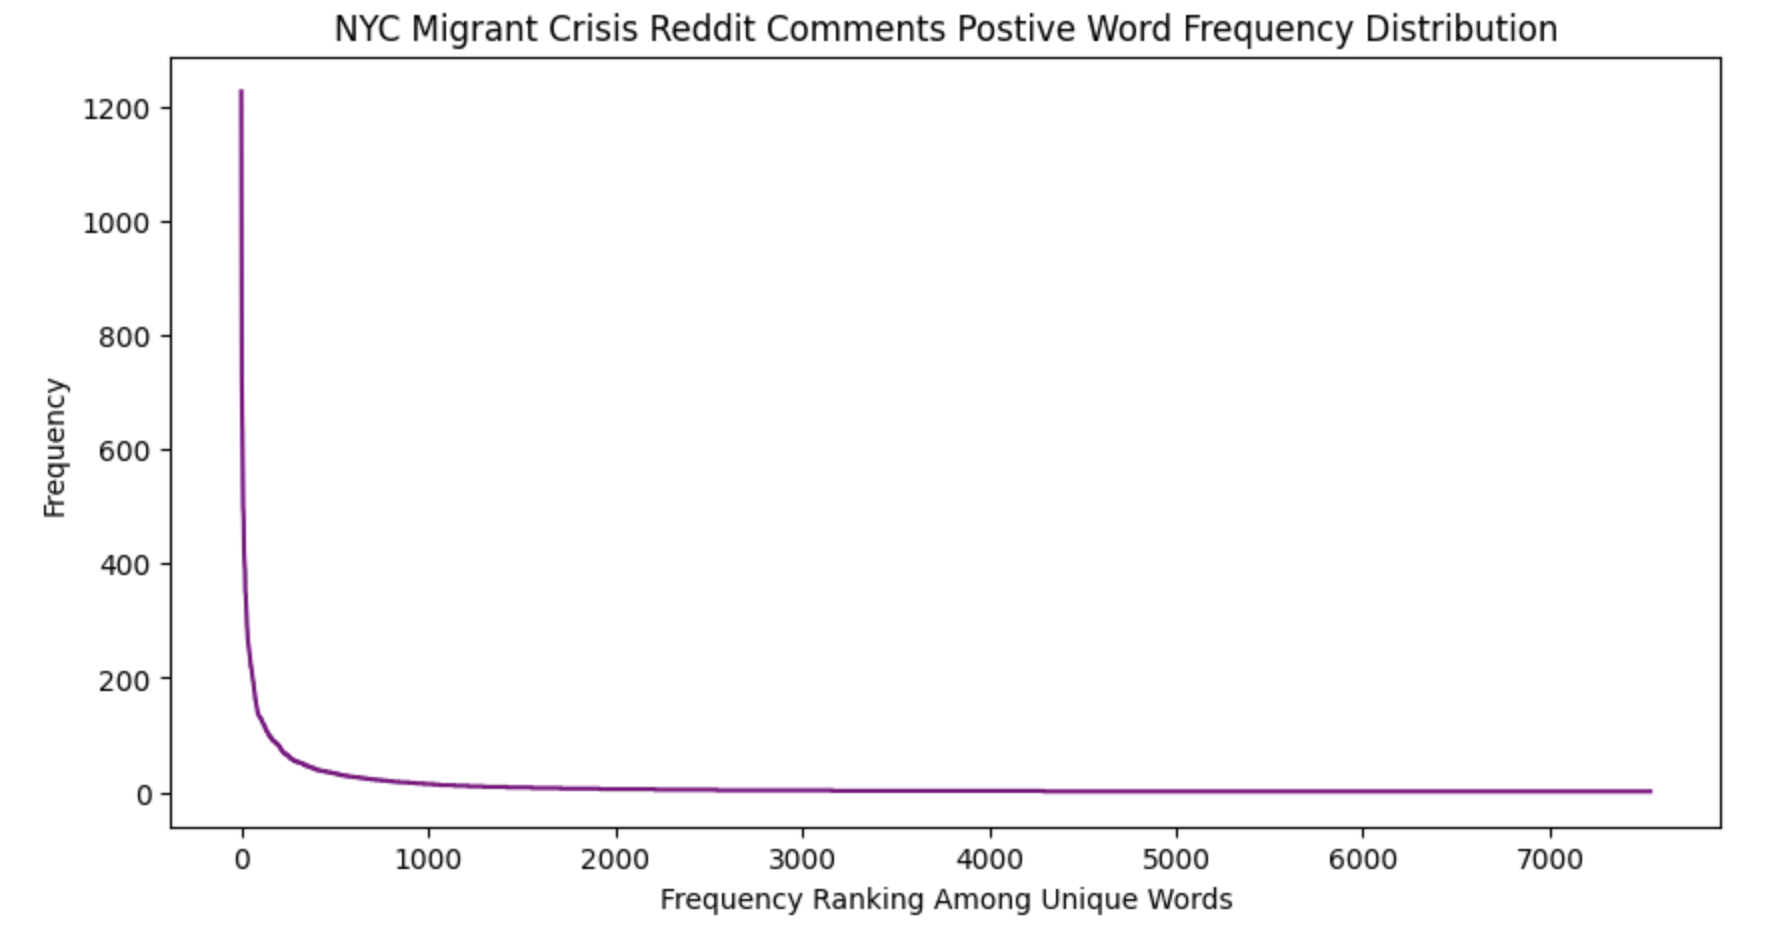

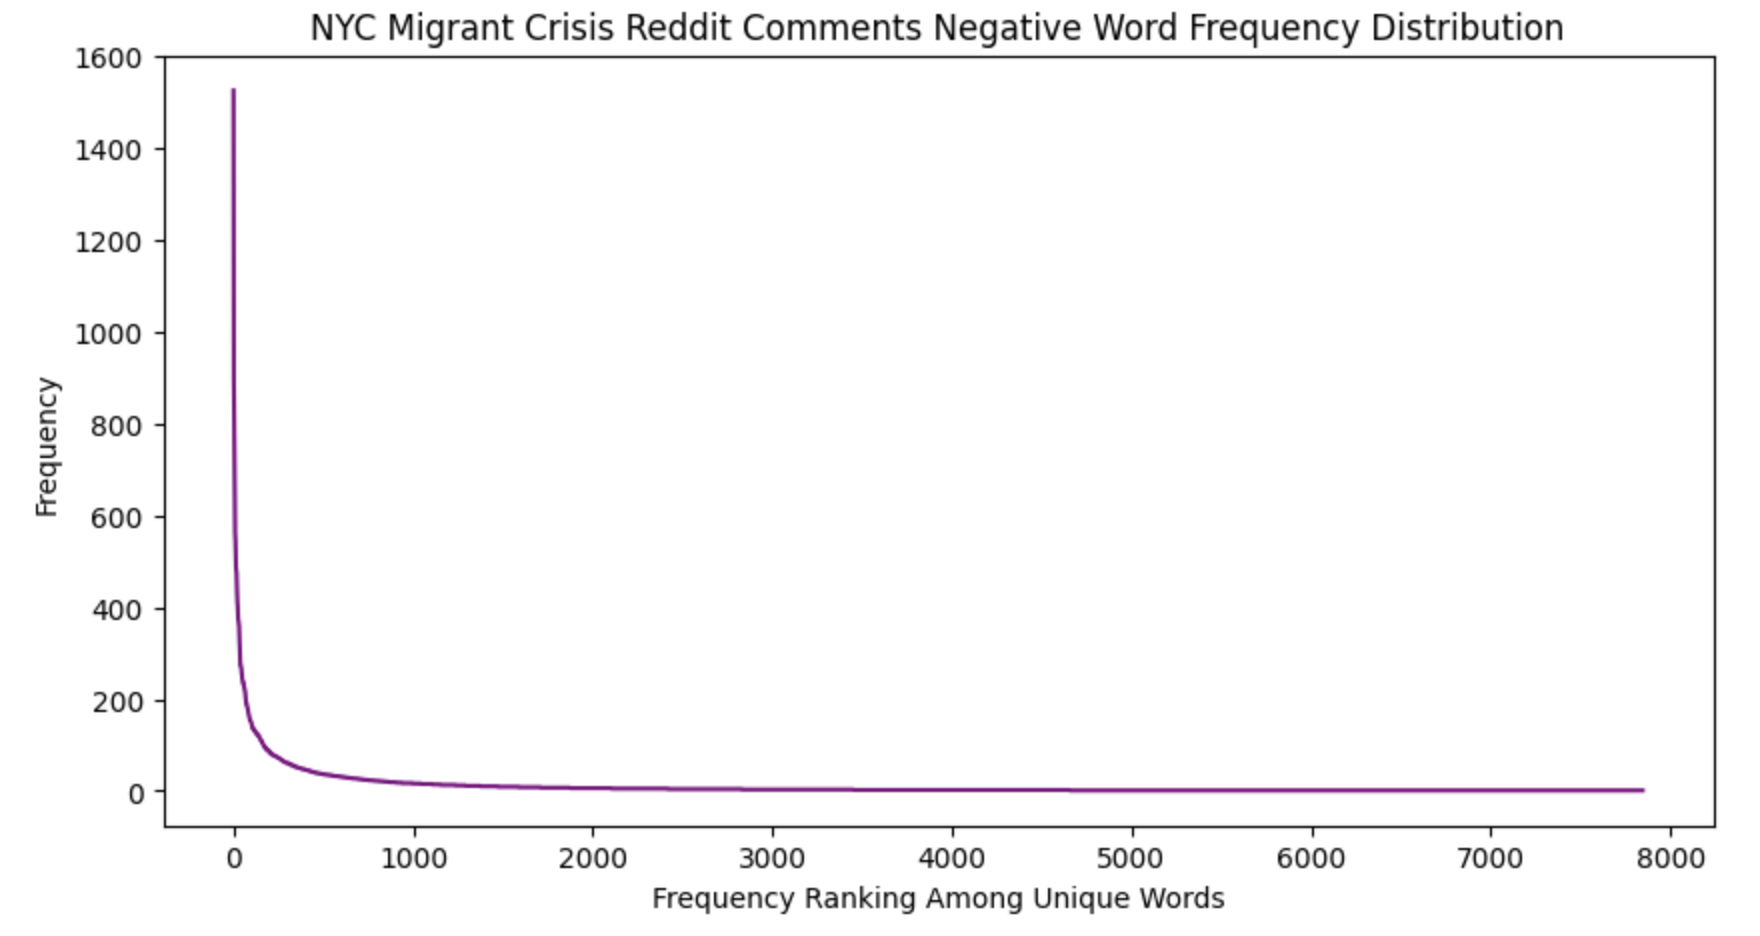

The power-law graphs show the frequency distribution of positive and negative words. According to this word frequency distribution, the sentiment analysis identified 7,538 unique words in the positive comments subset and 7,845 unique words in the negative comments subset, which aligns with the overall trend that there is a greater number of negative comments. For both the positive and negative distributions, words like "people," "like," "get," and "migrant" are extremely frequent, which provide context and are expected in natural language. The visibly flat tail of the graphs (and adherence to the power law) show that the majority of words occur rarely, indicating that the sample used for this analysis is a large and natural enough source of semantic and emotional information with respect to the migrant crisis. On the other hand, the common words that dominate both distributions indicate that there are many neutral words, and that the difference between the proportions of negative and positive sentiments is not so great.

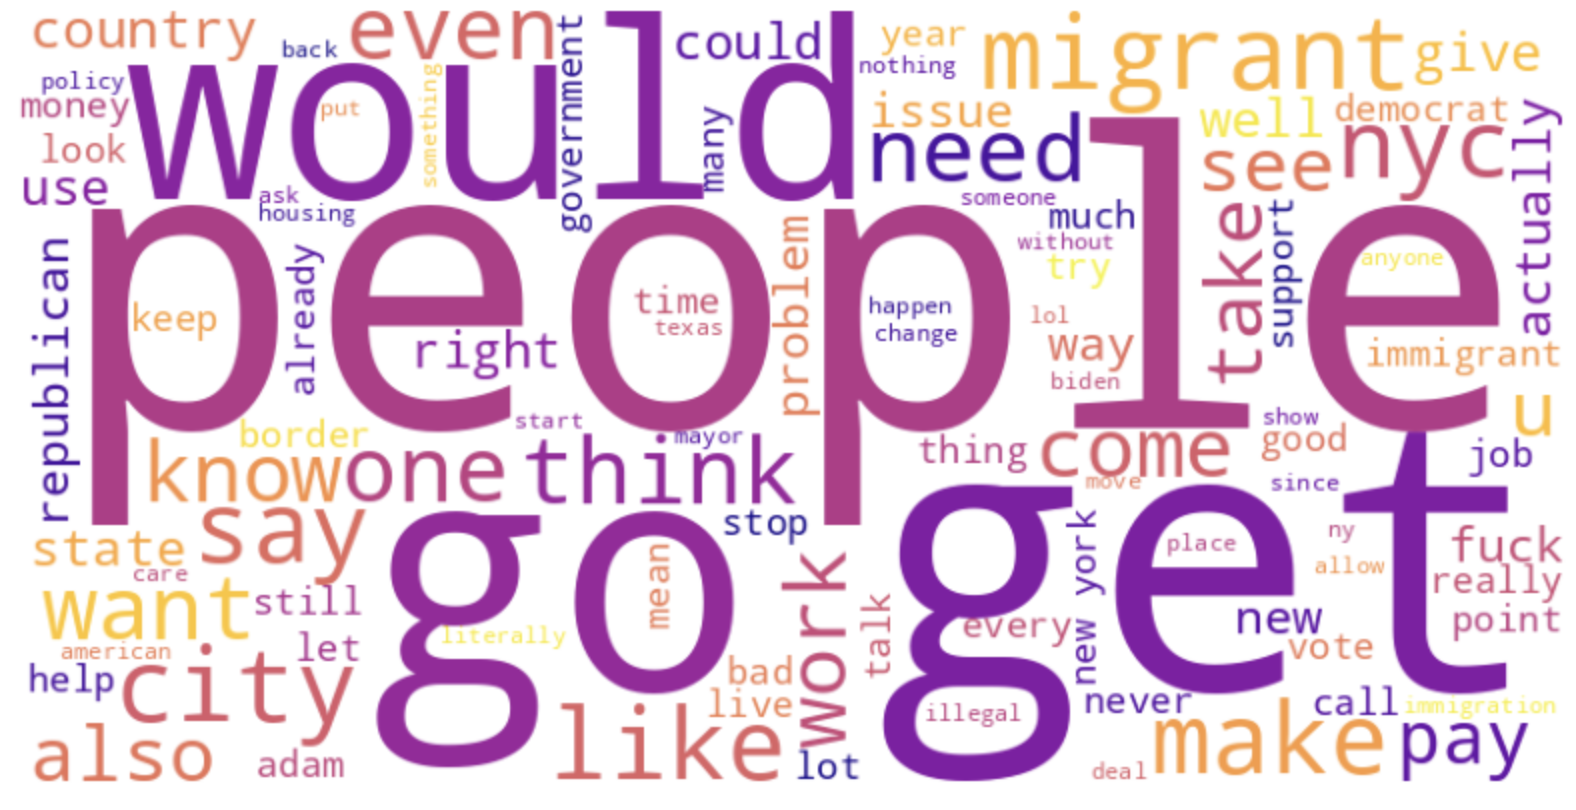

Finally, the word cloud accompanies the power law graph and visualizes the words that appear most commonly throughout the subreddits in a straightforward way. Evidently, a relatively balanced combination of positive, negative, and neutral attitudes is represented here. However, something I noticed is that the negative words featured come off more intense or opinionated than the positive words. For instance, some negative words that immediately stand out are profanities, “illegal,” “problem,” “stop,” and “take.” On the other hand, the positive words don’t seem to be as strongly positive in the sense that it is somewhat harder to differentiate words that are positive and neutral (or even negative, according to VADER).


## Conclusions and Limitations

In terms of potential political implications, the migrant crisis is very clearly a policy issue, as subreddit comments frequently mention political terms like Republican, Democrat, Mayor (Adams), and Biden. In addition, public discussions about the migrant crisis within relevant posts on Reddit reflect quite an even distribution of attitudes on the matter. Negative, positive, and neutral sentiments are all well-represented.

In terms of concrete political implications, a limitation of my investigation is that it lacks sufficient evidence to definitively draw links between Reddit sentiments and specific political identities. At the moment, while this analysis can recognize general sentiments about the topic, it is difficult to determine what parties these sentiments represent beyond subjective assumption. We can make speculations regarding which political parties are associated with particular stances because some political figures have been more vocal about their stance on immigration (especially Republican and Democratic), but this might not be representative of entire parties and simplifies an extremely complex subject. Proving the relationships requires further research, such as using a larger sample size or turning to other social media platforms like Twitter where it is less anonymous and, consequently, may be easier to associate posters and commenters with their political identities.

That being said, one possible interpretation of the current results is that the greater proportion of negative comments suggests that political parties that present policies aligned with these negative sentiments may gain more support than parties with lenient or absent policies. With this in mind, my hypothesis is supported.
